### Mounting drive

### imports

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image, ImageOps

### Set Paths

In [2]:
BASE_PATH = "."    # Change this to run in colab

RAW_DATA_FOLDER = "data"
MODIFIED_DATA_FOLDER = "generated"
TEMPORARY_DATA_FOLDER = "temp"

VIDEOS_METADATA_FILE = 'yt_metadata_en.jsonl.gz'
TECH_CATEGORY_FILE = 'science_and_technology_videos.csv'
SMARTPHONES_DATA = "Phone_to_Smartphone.csv"
VIDEOS_BRANDS_DATA = "videos_with_brands_metadeta.csv"

### Constants

In [3]:
VIDEOS_METADATA_COLUMNS = ["categories", "channel_id", 
                           "crawl_date", "description", 
                           "dislike_count", "display_id", 
                           "duration", "like_count", "tags", 
                           "title", "upload_date", "view_count"]

CATEGORY = 'Science & Technology'
CHUNK_SIZE = 500_000

MONTHS_NAMES = ["January", "February", "March", 
                "April", "May", "June", "July", 
                "August", "September", "October", 
                "November", "December"]

BRANDS_TO_ANALYZE = ["Samsung", "Apple" ,"LG", "Huawei", "Xiaomi", "Oppo", ]

## Utility Functions

In [ ]:
def capture_year(string):
    year = re.search('([0-9]{4})',string)
    if year:
        return int(year.group(0))
    else:
        return -1

In [ ]:
def get_brand_models(brand_name, df):
    return df[df.Brand == brand_name].Name.unique()

In [ ]:
def find_brand(row, brand_models):
    brands_mentioned = []
    for brand in brand_models.keys():
        for model in brand_models[brand]:
            model = model.lower()
            if (model in row.title.lower()
                or (model in row.description.lower())
                or model in row.tags.lower()):
                brands_mentioned.append(brand)
                break
    if len(brands_mentioned) == 0:
        return None
    return brands_mentioned

In [ ]:
def calc_release(row, months):
    year = row.released_year
    release = re.sub(r"\s*Released\s*", "", row.released_at, flags=re.IGNORECASE)
    
    full_date = re.search(r"[0-9]{4}, [a-z]+\s[0-9]{2}", release, flags=re.IGNORECASE)
    quarters_date = re.search(r"[0-9]{4}, [A-Z][1-4]", release, flags=re.IGNORECASE)
    months_date = re.search(r"[0-9]{4}, [a-z]+", release, flags=re.IGNORECASE)
    years_date = re.search(r"[0-9]{4}", release)
    
    if full_date:
        return pd.to_datetime(full_date.group(0))
    elif quarters_date:
        q = int(quarters_date.group(0)[-1])
        m = months[(q-1)*3 + 1]
        return pd.to_datetime("{}/{}".format(m, year))
    elif months_date:
        return pd.to_datetime(months_date.group(0))
    elif years_date:
        return pd.to_datetime(years_date.group(0))
    else:
        return None

In [ ]:
def get_plot(brands, column_name, aggregation, brand_videos, figsize=(20, 10), title="", x_label="", y_label="", interval="QS", whole_data=None) : 
    fig = plt.figure(figsize=figsize, dpi=80)
    
    for idx, brand in enumerate(brands):
        
        if brand != "Oppo":
            df = brand_videos[brand]

            #computing the mean per mont
            mean_views = df[column_name].resample(interval).agg(aggregation)
            mean_views[mean_views.isna()] = 0      # months where no video appear should have mean zero

            #plotting
            plt.plot(mean_views, label=brand, lw=3)
            #sns.lineplot(data=df[column_name], estimator=aggregation, label=brand, lw=3)#, x="upload_date", y=mean_views)

    #plotting the overall statistic
    if whole_data is not None:
        global_statisic = whole_data[column_name].resample(interval).agg(aggregation)
        global_statisic[global_statisic.isna()] = 0
        plt.plot(global_statisic, label="all data", lw=2, ls="--", color="grey") 
        #sns.lineplot(data=global_statisic, estimator=aggregation, label="all data", lw=2, ls="--", color="grey")


    #plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

## Videos Filtering

### Read Raw Data

In [4]:
%%time
raw_data_reader = pd.read_json(os.path.join(BASE_PATH, RAW_DATA_FOLDER, VIDEOS_METADATA_FILE), 
                           compression="infer", chunksize=CHUNK_SIZE, lines=True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


### Extract Tech and Science Videos

In [5]:
%%time
for data_chunk in tqdm(raw_data_reader):
    tech_videos = data_chunk[data_chunk.categories == CATEGORY]
    tech_videos.to_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, TECH_CATEGORY_FILE), 
                      mode='a', header=False, columns = WRITE_FILE_COLUMNS)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


### Load Tech & Science Videos Data

In [6]:
processed_data_reader = pd.read_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, TECH_CATEGORY_FILE), 
                                    names=WRITE_FILE_COLUMNS)

In [9]:
processed_data_reader.columns

Index(['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count'],
      dtype='object')

### Check and Clean Data

In [7]:
(processed_data_reader.dislike_count.isna() == processed_data_reader.like_count.isna()).sum() == len(processed_data_reader)

True

In [8]:
processed_data_reader.tags.replace(np.nan, "", inplace=True)
processed_data_reader.description.replace(np.nan, "", inplace=True)

## Phones & Tablets Filtering

### Load data 

In [3]:
phone_models_df = pd.read_csv(os.path.join(BASE_PATH, RAW_DATA_FOLDER, SMARTPHONES_DATA))

### Processing the release Date

In [5]:
phone_models_df["released_year"] = phone_models_df.released_at.apply(lambda x : capture_year(str(x)))

In [6]:
# Remove unreleased/Cancelled phones
phone_models_df.drop(phone_models_df[phone_models_df["released_year"] == -1].index, axis=0, inplace=True)

In [ ]:
filtered_phones["release"] = filtered_phones.apply(lambda x : calc_release(x, months_list), axis=1)

In [ ]:
filtered_phones[~filtered_phones.release.isna()].release.count()

In [ ]:
filtered_phones.count()

In [ ]:
filtered_phones = filtered_phones.set_index("release")

### Filter to Match timeframe with Videos

In [7]:
# Filter to match the range of youtube data
filtered_phones = phone_models_df[(phone_models_df["released_year"] > 2004) & (phone_models_df["released_year"] < 2020)]

In [8]:
filtered_phones.columns

Index(['id', 'Brand', 'Name', 'Status', 'coverImage', 'released_at', 'body',
       'os', 'Chipset', 'Colors', 'camera_pixels', 'battery_size', 'Type',
       'Dual', 'Triple', 'Charging', 'Size', 'Resolution',
       'Other_specifications', 'released_year'],
      dtype='object')

In [ ]:
filtered_phones.head()

### Show Brands with most Phones

In [10]:
filtered_phones.groupby("Brand").count()["id"].sort_values(ascending=False).head(50)

Brand
HP              35
i-mobile        37
Infinix         38
Haier           39
Maxwest         41
Archos          42
Tecno           42
Sharp           45
Apple           49
Pantech         52
T-Mobile        54
Prestigio       56
Meizu           57
Karbonn         60
Gigabyte        61
Icemobile       61
Sagem           67
Honor           68
Wiko            70
BlackBerry      76
Gionee          79
XOLO            81
Vodafone        84
QMobile         90
Panasonic       91
Yezz            93
Acer           100
Plum           107
Oppo           110
Xiaomi         112
Lava           116
Spice          119
vivo           128
verykool       139
Allview        149
Asus           171
Philips        176
Lenovo         198
Celkon         229
HTC            253
ZTE            258
Sony           275
Micromax       283
Huawei         287
BLU            304
alcatel        339
Motorola       347
Nokia          393
LG             570
Samsung       1085
Name: id, dtype: int64

### Retreive keywords (model names) associated to each Brand

In [12]:
brand_models = dict()

for brand in BRANDS_TO_ANALYZE:
    brand_models[brand] = get_brand_models(brand, filtered_phones)

## Filter Videos by Brands

In [21]:
%%time
processed_data_reader["brand"] =  processed_data_reader.apply(lambda x : find_brand(x, brand_models), axis=1)

CPU times: user 13h 30min 4s, sys: 2min 54s, total: 13h 32min 59s
Wall time: 1d 2h 54min 44s


In [22]:
processed_data_reader.to_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, VIDEOS_BRANDS_DATA))

### Clean Videos by Brand Data

In [14]:
branded_videos = pd.read_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, VIDEOS_BRANDS_DATA), index_col=0)

In [15]:
branded_videos.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,brand
3968,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:31.549534,Climate change threatens to make dry regions e...,503.0,XPSYzLZ7xKU,200,15328.0,"seeker,science,curiosity,education,explain,lea...",Transforming Air Into Pure Drinking Water Is F...,2019-10-03 00:00:00,357909.0,NaN
3969,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.224556,We now have a new understanding of the undergr...,84.0,WWD_1Nq6iwQ,308,6498.0,"seeker,science,curiosity,education,explain,lea...",This Underground Economy Exists in a Secret Fu...,2019-10-02 00:00:00,151492.0,NaN
3970,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.905550,Glaucoma is one of the leading causes of blind...,36.0,0U1rkFraBQo,399,2723.0,"SICK,science,health,health news,health tech,te...",How Does Glaucoma Cause Vision Loss?,2019-10-01 00:00:00,63057.0,NaN
3971,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:33.614600,NASA and Arizona State University plan to send...,111.0,NMknT8vKOL8,292,5274.0,"NASA,Arizona State University,asteroid,asteroi...",This Metal Asteroid Could Reveal Secrets About...,2019-09-30 00:00:00,229530.0,NaN
3972,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:34.300370,An international team of scientists and engine...,156.0,s0P9hj1R_Zw,486,10025.0,"focal point,documentary,interview,short doc,sc...","The International Hunt for Dark Energy Is On, ...",2019-09-29 00:00:00,322653.0,NaN


In [16]:
branded_videos = branded_videos[~branded_videos.brand.isna()]

In [ ]:
videos_by_brand = dict()
for brand in BRANDS_TO_ANALYZE:
    contains_this_brand = data_branded.brand.apply(lambda x : brand in x) 
    videos_by_brand[brand] = data_branded[contains_this_brand]

## Simple Analysis

In [ ]:
STATS = ['total_views','number_videos','average_views_video',
         'average_duration_video','nbr_channels_covering_brand',
         'nbr_vid_per_chnl_covering_brand','nbr_likes',
         'nbr_dislikes','like_dislike_ratio',
         'average_dislike_video','average_like_video',
         'percentage_like_per_viewer','percentage_dislike_per_viewer',
         'number_products','nbr_views_per_product']


# Computed by code
nbr_prodcts_brand = {'Samsung':1085,'Apple':49,'Xiaomi':112,'LG':570,'Huawei':287,'Oppo':110}

stats_brand_df =  pd.DataFrame(columns=STATS,index=BRANDS_TO_ANALYZE)

for brand in BRANDS_TO_ANALYZE:
    
    brand_df = videos_by_brand[brand]

    stats_brand_df.loc[brand].number_products = nbr_prodcts_brand[brand]
    stats_brand_df.loc[brand].total_views = int(brand_df.view_count.astype(float).sum())
    stats_brand_df.loc[brand].nbr_views_per_product = int(stats_brand_df.loc[brand].total_views/stats_brand_df.loc[brand].number_products)
    stats_brand_df.loc[brand].number_videos = len(brand_df)
    stats_brand_df.loc[brand].average_views_video = int((brand_df.view_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].average_duration_video = int(brand_df.duration.astype(float).mean())
    stats_brand_df.loc[brand].nbr_channels_covering_brand = int(brand_df.channel_id.nunique())
    stats_brand_df.loc[brand].nbr_likes = int(brand_df.like_count.astype(float).sum())
    stats_brand_df.loc[brand].nbr_dislikes = int(brand_df.dislike_count.astype(float).sum())
    stats_brand_df.loc[brand].like_dislike_ratio = stats_brand_df.loc[brand].nbr_likes/stats_brand_df.loc[brand].nbr_dislikes
    stats_brand_df.loc[brand].average_like_video = int((brand_df.like_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].percentage_like_per_viewer = (stats_brand_df.loc[brand].nbr_likes/stats_brand_df.loc[brand].total_views)*100
    stats_brand_df.loc[brand].average_dislike_video = int((brand_df.dislike_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].percentage_dislike_per_viewer = (stats_brand_df.loc[brand].nbr_dislikes/stats_brand_df.loc[brand].total_views)*100
    stats_brand_df.loc[brand].nbr_vid_per_chnl_covering_brand = stats_brand_df.loc[brand].number_videos/stats_brand_df.loc[brand].nbr_channels_covering_brand

### Visualization

In [ ]:
stats_brand_df.plot.pie(y='number_videos', figsize=(8, 8))

In [ ]:
stats_brand_df.plot.pie(y='average_duration_video', figsize=(8, 8)) 

In [ ]:
stats_brand_df[['total_views','number_videos',
                   'average_views_video','nbr_channels_covering_brand'
                  ]].plot.pie(subplots=True, figsize=(35, 18))

In [ ]:
stats_brand_df[['nbr_likes','average_like_video',
                   'percentage_like_per_viewer'
                  ]].plot.pie(subplots=True, figsize=(35, 18))

In [ ]:
stats_brand_df[['nbr_dislikes','average_dislike_video',
                'percentage_dislike_per_viewer'
               ]].plot.pie(subplots=True, figsize=(35, 18))

In [ ]:
stats_brand_df[['like_dislike_ratio','nbr_vid_per_chnl_covering_brand',
                'nbr_views_per_product'
               ]].plot.pie(subplots=True, figsize=(35, 18))

In [ ]:
plt = stats_brand_df.plot.scatter(x='percentage_like_per_viewer',
                                  y='percentage_dislike_per_viewer',figsize=(10, 6))
for i in range(len(stats_brand_df)):
    plt.annotate(str(stats_brand_df.index[i]),(stats_brand_df.percentage_like_per_viewer[i], 
               stats_brand_df.percentage_dislike_per_viewer[i]))

In [ ]:
plt = stats_brand_df.plot.scatter(x='total_views',
                                  y='average_views_video',figsize=(10, 6))
for i in range(len(stats_brand_df)):
    plt.annotate(str(stats_brand_df.index[i]),(stats_brand_df.total_views[i], 
                   stats_brand_df.average_views_video[i]))

In [ ]:
plt = stats_brand_df.plot.scatter(x='total_views',
                                  y='nbr_views_per_product',figsize=(10, 6))
for i in range(len(stats_brand_df)):
    plt.annotate(str(stats_brand_df.index[i]),(stats_brand_df.total_views[i], 
                   stats_brand_df.nbr_views_per_product[i]))

In [ ]:
plt = stats_brand_df.plot.scatter(x='number_videos',
                                  y='nbr_channels_covering_brand',figsize=(10, 6))
for i in range(len(stats_brand_df)):
    plt.annotate(str(stats_brand_df.index[i]),(stats_brand_df.number_videos[i], 
                   stats_brand_df.nbr_channels_covering_brand[i]))

## Timeseries Visualizations

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "view_count", "mean", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS", whole_data=branded_videos)

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "view_count", "sum", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS")

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "view_count", "std", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS", whole_data=branded_videos)

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "like_count", "mean", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS", whole_data=branded_videos)

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "like_count", "sum", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS")

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "like_count", "std", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS", whole_data=branded_videos)

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "duration", "mean", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS", whole_data=branded_videos)

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "duration", "sum", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS")

In [ ]:
get_plot(BRANDS_TO_ANALYZE, "duration", "std", 
         videos_by_brand, figsize=(20, 10), y_label="Number of views", x_label="date", 
         title="Number of views for videos of different brands with respect to time", 
         interval="QS", whole_data=branded_videos)

In [ ]:
get_plot(BRANDS, "channel_id", "nunique", 
         videos_by_brand, y_label="Number of channels", x_label="date", 
         title="Number of channels for videos of different brands with respect to time", 
         interval="QS",  whole_data=data_branded)

### Create Word Clouds

In [63]:
sample = brand_videos["Apple"].title

In [64]:
words = ""

for index, title in sample.items():
#     print(title)
    words += title + " "

In [223]:
img = Image.open("Apple Logo.png")
img.size

(1024, 1024)

In [224]:
img_invert = ImageOps.grayscale(img)

In [225]:
apple_mask = np.array(img_invert)
apple_mask.shape

(1024, 1024)

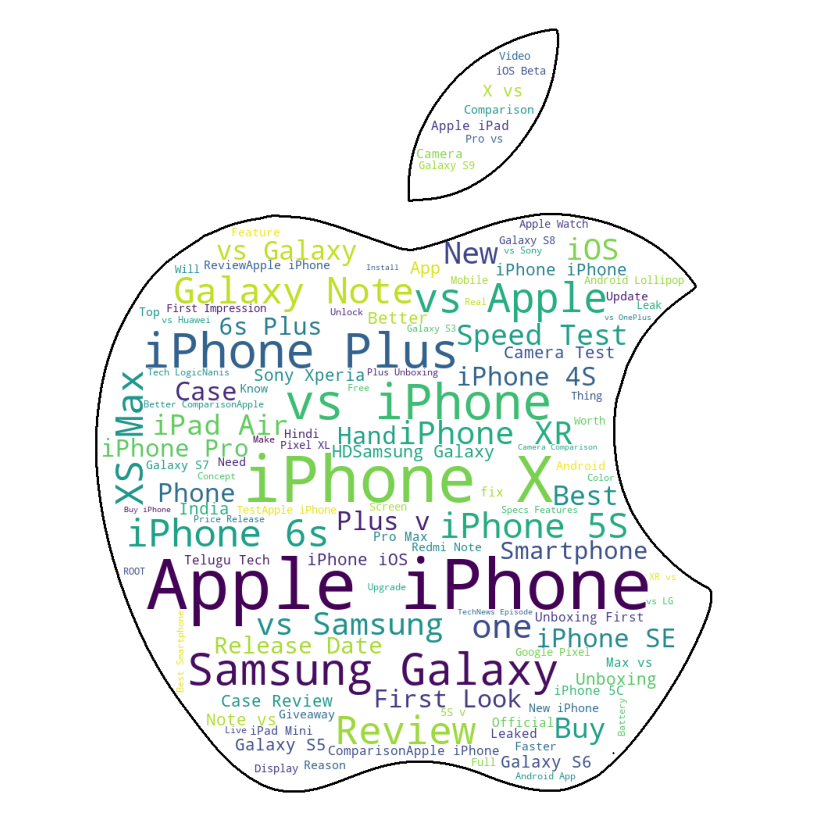

In [227]:
wordcloud = WordCloud(
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10,
                mask=apple_mask,
#                 max_words=500,
                contour_width=3, contour_color='black')

wordcloud.generate(words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()